In [194]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
import dynamic_tsne
from importlib import reload
reload(dynamic_tsne)  # Rerun this cell after update
%matplotlib inline

We are going to use mainly 2 datasets for illustration: iris dataset [ref] and 8x8 digit pictures dataset [ref].
 - Iris dataset is a popular example dataset for classification. It contains petal length, petal width, sepal length and sepal width of the iris flower, and has the type of flower as expected output (setosa, versicolor or virginica).
 - Written digits, represented as 8x8 images. Each pixel is a grayscale value between 0 and 1, where 0 means white, 1 means black, and values between are shades of gray.
 
Both datasets were taken from scikit-learn [ref] package.

In [195]:
# Load data
data_digits = datasets.load_digits()
X_digits = data_digits.images.reshape((-1, 64)) # 8x8 image to 64-length vector
labels_digits = data_digits.target

temp = np.ascontiguousarray(X_digits).view(np.dtype((np.void, X_digits.dtype.itemsize * X_digits.shape[1])))
_, un_idx = np.unique(temp, return_index=True)
X_digits = X_digits[un_idx, :]
labels_digits = labels_digits[un_idx]

In [196]:
# Run TSNE
dTSNE_digits = dynamic_tsne.DynamicTSNE(perplexity=20)
Y_digits = dTSNE_digits.fit(X_digits, optimizer_kwargs={'momentum': 0.8, 'n_iter': 1000}, random_seed=1)

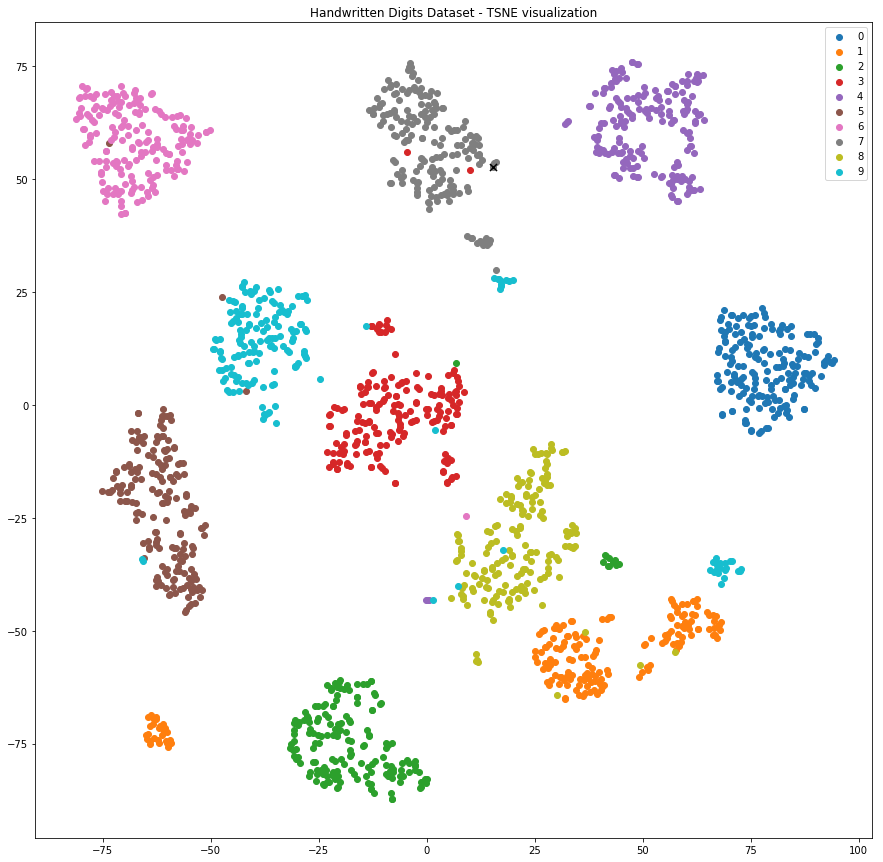

In [258]:
plt.gcf().set_size_inches(15,15)
legend_list = list()
for l in set(sorted(labels_digits)):
    plt.scatter(Y_digits[labels_digits == l, 0], Y_digits[labels_digits == l, 1])
    legend_list.append(str(data_digits.target_names[l]))
plt.title("Handwritten Digits Dataset - TSNE visualization")
plt.scatter(Y_digits[[75], 0], Y_digits[[75], 1], marker = 'x', color='black',s=50)
plt.legend(legend_list)
plt.show()

In [162]:
data_iris = datasets.load_iris()
X_iris = data_iris.data
labels_iris = data_iris.target

# Keeping only unique rows. There is way easier method in numpy 1.13
temp = np.ascontiguousarray(X_iris).view(np.dtype((np.void, X_iris.dtype.itemsize * X_iris.shape[1])))
_, unique_idx = np.unique(temp, return_index=True)

X_iris = X_iris[unique_idx, :]
labels_iris = labels_iris[unique_idx]

In [163]:
dTSNE_iris = dynamic_tsne.DynamicTSNE(perplexity=20)
# Small dataset. Iterations are very fast, we can afford more
Y_iris = dTSNE_iris.fit(X_iris, verbose=0, optimizer_kwargs={'momentum': 0.8, 'n_iter' : 3000}, random_seed=1)

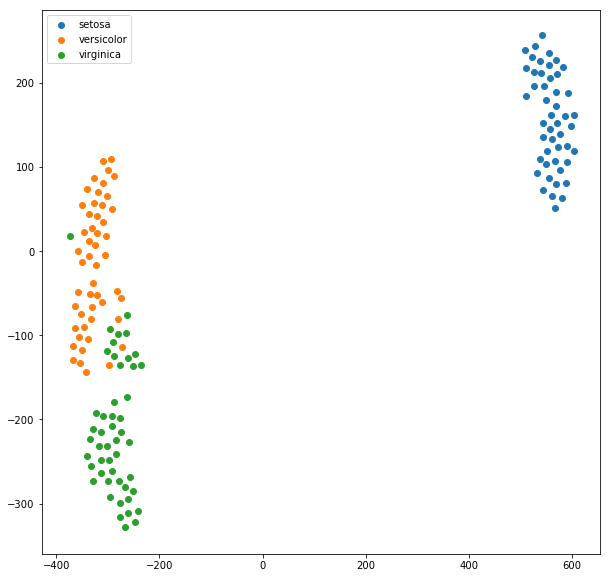

In [164]:
plt.gcf().set_size_inches(10, 10)
legend_list = list()
for l in set(sorted(labels_iris)):
    plt.scatter(Y_iris[labels_iris == l, 0], Y_iris[labels_iris == l, 1])
    legend_list.append(str(data_iris.target_names[l]))
plt.legend(legend_list)
plt.show()

One of the main limitation of TSNE is that it is essentially a one-shot method: once transformation is done, algorithm is not designed to incorporate new data. There are two exaple scenarios where that limitation can come into play:
- Additional examples appearing. If we receive new digit, where should it be in the map? If there is a new iris flower, where will it be? [add real-life examples]
- Dynamics. If the data changes over time, how to estimate the movement of existing data point?

## Approach 1. Refitting.

One possible option is to re-run the gradient descent for new points. [and there are a lot of tricks, TODO]

In [165]:
# TODO

We design the following test:
- Take two samples [not exactly at random for now]
- Generate linearly transform one sample to another and record the transition steps.
- Generate Y for each step using the embedding function.
- In X space transition will be linear. How will it look in Y space? [Note: it does not have to be linear]

There are no formal criteria, [we just hope for insights]

In [242]:
start_index = 75
end_index = 228
steps = 100
X_digits_transition = [X_digits[start_index, :] + (X_digits[end_index,:] - X_digits[start_index, :])*i/steps
                       for i in range(steps+1)]

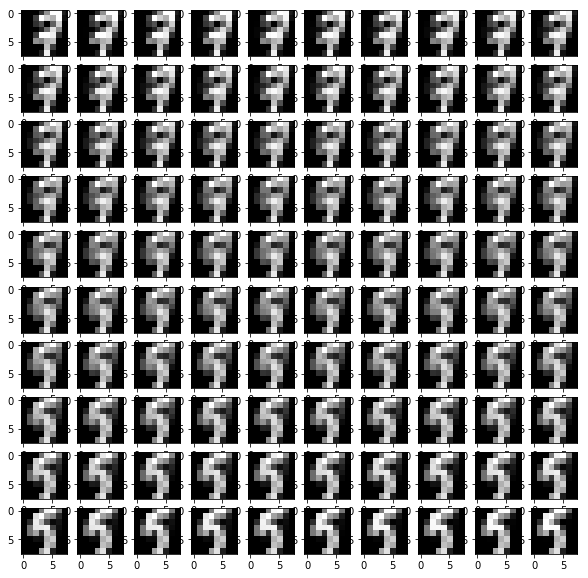

In [244]:
f, ax = plt.subplots(10,10)
f.set_size_inches(10,10)
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(X_digits_transition[i*10+j].reshape(8,8), cmap = 'gray')

In [168]:
start_index = 0
end_index = 100
steps = 100
Xtransition_iris = [X_iris[start_index, :] + (X_iris[end_index,:] - X_iris[start_index, :])*i/steps
                    for i in range(steps+1)]
ytransition = [Y_iris[start_index] + (Y_iris[end_index] - Y_iris[start_index])*i/steps for i in range(steps+1)]

In [169]:
y_iris_closest = dTSNE_iris.transform(Xtransition_iris, y='closest', verbose=2, random_seed=1)
y_iris_random = dTSNE_iris.transform(Xtransition_iris, y='random', verbose=2, random_seed=1)
y_iris_linear = dTSNE_iris.transform(Xtransition_iris, y=ytransition, verbose=2, random_seed=1)

Found sigma. Average:  0.269351002881
[t-SNE] Iteration 1: error = 20.9776524, gradient norm = 0.0047330
[t-SNE] Iteration 2: error = 20.7698535, gradient norm = 0.0340361
[t-SNE] Iteration 3: error = 17.1632661, gradient norm = 0.0440053
[t-SNE] Iteration 4: error = 16.8895121, gradient norm = 0.0517782
[t-SNE] Iteration 5: error = 15.1128859, gradient norm = 0.0514014
[t-SNE] Iteration 6: error = 13.3644880, gradient norm = 0.0533483
[t-SNE] Iteration 7: error = 12.6514716, gradient norm = 0.0702372
[t-SNE] Iteration 8: error = 12.2613505, gradient norm = 0.0663718
[t-SNE] Iteration 9: error = 11.9192051, gradient norm = 0.0731100
[t-SNE] Iteration 10: error = 11.4960599, gradient norm = 0.0671023
[t-SNE] Iteration 11: error = 11.1507761, gradient norm = 0.0524413
[t-SNE] Iteration 12: error = 11.1423345, gradient norm = 0.0546226
[t-SNE] Iteration 13: error = 11.2046890, gradient norm = 0.0732603
[t-SNE] Iteration 14: error = 11.1128771, gradient norm = 0.0408168
[t-SNE] Iteration 1

[t-SNE] Iteration 170: error = 0.7931865, gradient norm = 0.0003451
[t-SNE] Iteration 171: error = 0.7903841, gradient norm = 0.0003351
[t-SNE] Iteration 172: error = 0.7879676, gradient norm = 0.0003505
[t-SNE] Iteration 173: error = 0.7856321, gradient norm = 0.0003423
[t-SNE] Iteration 174: error = 0.7834139, gradient norm = 0.0003427
[t-SNE] Iteration 175: error = 0.7812347, gradient norm = 0.0003443
[t-SNE] Iteration 176: error = 0.7789669, gradient norm = 0.0003387
[t-SNE] Iteration 177: error = 0.7766992, gradient norm = 0.0003220
[t-SNE] Iteration 178: error = 0.7747589, gradient norm = 0.0003248
[t-SNE] Iteration 179: error = 0.7730779, gradient norm = 0.0003311
[t-SNE] Iteration 180: error = 0.7714823, gradient norm = 0.0002691
[t-SNE] Iteration 181: error = 0.7702374, gradient norm = 0.0002567
[t-SNE] Iteration 182: error = 0.7691334, gradient norm = 0.0002608
[t-SNE] Iteration 183: error = 0.7680207, gradient norm = 0.0002497
[t-SNE] Iteration 184: error = 0.7669244, gradie

[t-SNE] Iteration 344: error = 0.5420807, gradient norm = 0.0000308
[t-SNE] Iteration 345: error = 0.5420506, gradient norm = 0.0000302
[t-SNE] Iteration 346: error = 0.5420211, gradient norm = 0.0000296
[t-SNE] Iteration 347: error = 0.5419922, gradient norm = 0.0000291
[t-SNE] Iteration 348: error = 0.5419639, gradient norm = 0.0000286
[t-SNE] Iteration 349: error = 0.5419361, gradient norm = 0.0000281
[t-SNE] Iteration 350: error = 0.5419089, gradient norm = 0.0000277
[t-SNE] Iteration 351: error = 0.5418821, gradient norm = 0.0000273
[t-SNE] Iteration 352: error = 0.5418558, gradient norm = 0.0000269
[t-SNE] Iteration 353: error = 0.5418299, gradient norm = 0.0000265
[t-SNE] Iteration 354: error = 0.5418045, gradient norm = 0.0000261
[t-SNE] Iteration 355: error = 0.5417795, gradient norm = 0.0000258
[t-SNE] Iteration 356: error = 0.5417548, gradient norm = 0.0000255
[t-SNE] Iteration 357: error = 0.5417305, gradient norm = 0.0000251
[t-SNE] Iteration 358: error = 0.5417066, gradie

[t-SNE] Iteration 520: error = 0.5401554, gradient norm = 0.0000081
[t-SNE] Iteration 521: error = 0.5401517, gradient norm = 0.0000079
[t-SNE] Iteration 522: error = 0.5401480, gradient norm = 0.0000081
[t-SNE] Iteration 523: error = 0.5401443, gradient norm = 0.0000077
[t-SNE] Iteration 524: error = 0.5401407, gradient norm = 0.0000081
[t-SNE] Iteration 525: error = 0.5401370, gradient norm = 0.0000079
[t-SNE] Iteration 526: error = 0.5401334, gradient norm = 0.0000087
[t-SNE] Iteration 527: error = 0.5401298, gradient norm = 0.0000087
[t-SNE] Iteration 528: error = 0.5401263, gradient norm = 0.0000101
[t-SNE] Iteration 529: error = 0.5401227, gradient norm = 0.0000086
[t-SNE] Iteration 530: error = 0.5401192, gradient norm = 0.0000081
[t-SNE] Iteration 531: error = 0.5401159, gradient norm = 0.0000079
[t-SNE] Iteration 532: error = 0.5401126, gradient norm = 0.0000078
[t-SNE] Iteration 533: error = 0.5401094, gradient norm = 0.0000081
[t-SNE] Iteration 534: error = 0.5401061, gradie

[t-SNE] Iteration 688: error = 0.5397040, gradient norm = 0.0000067
[t-SNE] Iteration 689: error = 0.5397016, gradient norm = 0.0000069
[t-SNE] Iteration 690: error = 0.5396991, gradient norm = 0.0000069
[t-SNE] Iteration 691: error = 0.5396967, gradient norm = 0.0000076
[t-SNE] Iteration 692: error = 0.5396942, gradient norm = 0.0000080
[t-SNE] Iteration 693: error = 0.5396917, gradient norm = 0.0000083
[t-SNE] Iteration 694: error = 0.5396892, gradient norm = 0.0000076
[t-SNE] Iteration 695: error = 0.5396868, gradient norm = 0.0000071
[t-SNE] Iteration 696: error = 0.5396844, gradient norm = 0.0000067
[t-SNE] Iteration 697: error = 0.5396819, gradient norm = 0.0000067
[t-SNE] Iteration 698: error = 0.5396795, gradient norm = 0.0000067
[t-SNE] Iteration 699: error = 0.5396771, gradient norm = 0.0000067
[t-SNE] Iteration 700: error = 0.5396747, gradient norm = 0.0000066
[t-SNE] Iteration 701: error = 0.5396722, gradient norm = 0.0000068
[t-SNE] Iteration 702: error = 0.5396697, gradie

[t-SNE] Iteration 860: error = 0.5391317, gradient norm = 0.0000086
[t-SNE] Iteration 861: error = 0.5391274, gradient norm = 0.0000087
[t-SNE] Iteration 862: error = 0.5391231, gradient norm = 0.0000087
[t-SNE] Iteration 863: error = 0.5391188, gradient norm = 0.0000087
[t-SNE] Iteration 864: error = 0.5391145, gradient norm = 0.0000086
[t-SNE] Iteration 865: error = 0.5391101, gradient norm = 0.0000088
[t-SNE] Iteration 866: error = 0.5391057, gradient norm = 0.0000088
[t-SNE] Iteration 867: error = 0.5391012, gradient norm = 0.0000092
[t-SNE] Iteration 868: error = 0.5390967, gradient norm = 0.0000092
[t-SNE] Iteration 869: error = 0.5390922, gradient norm = 0.0000095
[t-SNE] Iteration 870: error = 0.5390876, gradient norm = 0.0000091
[t-SNE] Iteration 871: error = 0.5390830, gradient norm = 0.0000091
[t-SNE] Iteration 872: error = 0.5390784, gradient norm = 0.0000087
[t-SNE] Iteration 873: error = 0.5390737, gradient norm = 0.0000088
[t-SNE] Iteration 874: error = 0.5390690, gradie

[t-SNE] Iteration 13: error = 15.3603952, gradient norm = 0.0611265
[t-SNE] Iteration 14: error = 15.5795729, gradient norm = 0.0706862
[t-SNE] Iteration 15: error = 14.7719847, gradient norm = 0.0466888
[t-SNE] Iteration 16: error = 15.2119640, gradient norm = 0.0812511
[t-SNE] Iteration 17: error = 14.8826661, gradient norm = 0.0623671
[t-SNE] Iteration 18: error = 15.0243790, gradient norm = 0.0893354
[t-SNE] Iteration 19: error = 14.5536512, gradient norm = 0.0609009
[t-SNE] Iteration 20: error = 14.3940889, gradient norm = 0.0668361
[t-SNE] Iteration 21: error = 14.8841633, gradient norm = 0.0928292
[t-SNE] Iteration 22: error = 14.3880733, gradient norm = 0.0879150
[t-SNE] Iteration 23: error = 14.2797774, gradient norm = 0.1004448
[t-SNE] Iteration 24: error = 13.8828244, gradient norm = 0.0935681
[t-SNE] Iteration 25: error = 13.6809550, gradient norm = 0.0698081
[t-SNE] Iteration 26: error = 13.1661690, gradient norm = 0.0246653
[t-SNE] Iteration 27: error = 12.9861438, gradie

[t-SNE] Iteration 168: error = 1.4166749, gradient norm = 0.0003620
[t-SNE] Iteration 169: error = 1.4135198, gradient norm = 0.0003572
[t-SNE] Iteration 170: error = 1.4104185, gradient norm = 0.0003519
[t-SNE] Iteration 171: error = 1.4073822, gradient norm = 0.0003461
[t-SNE] Iteration 172: error = 1.4044213, gradient norm = 0.0003401
[t-SNE] Iteration 173: error = 1.4015417, gradient norm = 0.0003348
[t-SNE] Iteration 174: error = 1.3987364, gradient norm = 0.0003313
[t-SNE] Iteration 175: error = 1.3959800, gradient norm = 0.0003297
[t-SNE] Iteration 176: error = 1.3932421, gradient norm = 0.0003288
[t-SNE] Iteration 177: error = 1.3905101, gradient norm = 0.0003279
[t-SNE] Iteration 178: error = 1.3877851, gradient norm = 0.0003266
[t-SNE] Iteration 179: error = 1.3850759, gradient norm = 0.0003245
[t-SNE] Iteration 180: error = 1.3823940, gradient norm = 0.0003220
[t-SNE] Iteration 181: error = 1.3797466, gradient norm = 0.0003200
[t-SNE] Iteration 182: error = 1.3771284, gradie

[t-SNE] Iteration 315: error = 1.0486016, gradient norm = 0.0001707
[t-SNE] Iteration 316: error = 1.0473885, gradient norm = 0.0001699
[t-SNE] Iteration 317: error = 1.0462008, gradient norm = 0.0001692
[t-SNE] Iteration 318: error = 1.0450350, gradient norm = 0.0001685
[t-SNE] Iteration 319: error = 1.0438856, gradient norm = 0.0001679
[t-SNE] Iteration 320: error = 1.0427454, gradient norm = 0.0001675
[t-SNE] Iteration 321: error = 1.0416065, gradient norm = 0.0001673
[t-SNE] Iteration 322: error = 1.0404635, gradient norm = 0.0001674
[t-SNE] Iteration 323: error = 1.0393128, gradient norm = 0.0001678
[t-SNE] Iteration 324: error = 1.0381511, gradient norm = 0.0001686
[t-SNE] Iteration 325: error = 1.0369741, gradient norm = 0.0001699
[t-SNE] Iteration 326: error = 1.0357771, gradient norm = 0.0001715
[t-SNE] Iteration 327: error = 1.0345555, gradient norm = 0.0001733
[t-SNE] Iteration 328: error = 1.0333054, gradient norm = 0.0001753
[t-SNE] Iteration 329: error = 1.0320232, gradie

[t-SNE] Iteration 469: error = 0.6701483, gradient norm = 0.0001858
[t-SNE] Iteration 470: error = 0.6694450, gradient norm = 0.0001650
[t-SNE] Iteration 471: error = 0.6687796, gradient norm = 0.0001575
[t-SNE] Iteration 472: error = 0.6681408, gradient norm = 0.0001539
[t-SNE] Iteration 473: error = 0.6675198, gradient norm = 0.0001510
[t-SNE] Iteration 474: error = 0.6669104, gradient norm = 0.0001511
[t-SNE] Iteration 475: error = 0.6663064, gradient norm = 0.0001509
[t-SNE] Iteration 476: error = 0.6657066, gradient norm = 0.0001541
[t-SNE] Iteration 477: error = 0.6651062, gradient norm = 0.0001542
[t-SNE] Iteration 478: error = 0.6645015, gradient norm = 0.0001540
[t-SNE] Iteration 479: error = 0.6638933, gradient norm = 0.0001518
[t-SNE] Iteration 480: error = 0.6632822, gradient norm = 0.0001528
[t-SNE] Iteration 481: error = 0.6626636, gradient norm = 0.0001541
[t-SNE] Iteration 482: error = 0.6620354, gradient norm = 0.0001544
[t-SNE] Iteration 483: error = 0.6613974, gradie

[t-SNE] Iteration 109: error = 1.4435172, gradient norm = 0.0004447
[t-SNE] Iteration 110: error = 1.4408604, gradient norm = 0.0004351
[t-SNE] Iteration 111: error = 1.4382411, gradient norm = 0.0004260
[t-SNE] Iteration 112: error = 1.4356610, gradient norm = 0.0004175
[t-SNE] Iteration 113: error = 1.4331177, gradient norm = 0.0004098
[t-SNE] Iteration 114: error = 1.4306069, gradient norm = 0.0004027
[t-SNE] Iteration 115: error = 1.4281254, gradient norm = 0.0003958
[t-SNE] Iteration 116: error = 1.4256718, gradient norm = 0.0003890
[t-SNE] Iteration 117: error = 1.4232446, gradient norm = 0.0003824
[t-SNE] Iteration 118: error = 1.4208423, gradient norm = 0.0003759
[t-SNE] Iteration 119: error = 1.4184628, gradient norm = 0.0003698
[t-SNE] Iteration 120: error = 1.4161020, gradient norm = 0.0003645
[t-SNE] Iteration 121: error = 1.4137530, gradient norm = 0.0003604
[t-SNE] Iteration 122: error = 1.4114055, gradient norm = 0.0003574
[t-SNE] Iteration 123: error = 1.4090481, gradie

[t-SNE] Iteration 265: error = 0.8922498, gradient norm = 0.0002120
[t-SNE] Iteration 266: error = 0.8909198, gradient norm = 0.0001969
[t-SNE] Iteration 267: error = 0.8896466, gradient norm = 0.0001742
[t-SNE] Iteration 268: error = 0.8884476, gradient norm = 0.0001454
[t-SNE] Iteration 269: error = 0.8873896, gradient norm = 0.0001512
[t-SNE] Iteration 270: error = 0.8863284, gradient norm = 0.0001512
[t-SNE] Iteration 271: error = 0.8852241, gradient norm = 0.0001475
[t-SNE] Iteration 272: error = 0.8840782, gradient norm = 0.0001470
[t-SNE] Iteration 273: error = 0.8828827, gradient norm = 0.0001480
[t-SNE] Iteration 274: error = 0.8816281, gradient norm = 0.0001508
[t-SNE] Iteration 275: error = 0.8803032, gradient norm = 0.0001540
[t-SNE] Iteration 276: error = 0.8788995, gradient norm = 0.0001569
[t-SNE] Iteration 277: error = 0.8774084, gradient norm = 0.0001601
[t-SNE] Iteration 278: error = 0.8758151, gradient norm = 0.0001641
[t-SNE] Iteration 279: error = 0.8740978, gradie

[t-SNE] Iteration 420: error = 0.7685806, gradient norm = 0.0001088
[t-SNE] Iteration 421: error = 0.7680399, gradient norm = 0.0001103
[t-SNE] Iteration 422: error = 0.7674876, gradient norm = 0.0001120
[t-SNE] Iteration 423: error = 0.7669215, gradient norm = 0.0001140
[t-SNE] Iteration 424: error = 0.7663392, gradient norm = 0.0001163
[t-SNE] Iteration 425: error = 0.7657375, gradient norm = 0.0001191
[t-SNE] Iteration 426: error = 0.7651126, gradient norm = 0.0001225
[t-SNE] Iteration 427: error = 0.7644599, gradient norm = 0.0001268
[t-SNE] Iteration 428: error = 0.7637737, gradient norm = 0.0001320
[t-SNE] Iteration 429: error = 0.7630475, gradient norm = 0.0001382
[t-SNE] Iteration 430: error = 0.7622740, gradient norm = 0.0001454
[t-SNE] Iteration 431: error = 0.7614463, gradient norm = 0.0001526
[t-SNE] Iteration 432: error = 0.7605611, gradient norm = 0.0001585
[t-SNE] Iteration 433: error = 0.7596239, gradient norm = 0.0001610
[t-SNE] Iteration 434: error = 0.7586530, gradie

[t-SNE] Iteration 577: error = 0.9269881, gradient norm = 0.0005405
[t-SNE] Iteration 578: error = 0.9396096, gradient norm = 0.0003551
[t-SNE] Iteration 579: error = 0.9443037, gradient norm = 0.0006872
[t-SNE] Iteration 580: error = 0.9478675, gradient norm = 0.0011672
[t-SNE] Iteration 581: error = 0.9560620, gradient norm = 0.0058282
[t-SNE] Iteration 582: error = 0.9778412, gradient norm = 0.0095221
[t-SNE] Iteration 583: error = 0.9756899, gradient norm = 0.0018612
[t-SNE] Iteration 584: error = 1.0693049, gradient norm = 0.1270892
[t-SNE] Iteration 585: error = 1.0478813, gradient norm = 0.0012328
[t-SNE] Iteration 586: error = 1.0617952, gradient norm = 0.0014115
[t-SNE] Iteration 587: error = 1.0648503, gradient norm = 0.0006865
[t-SNE] Iteration 588: error = 1.0644596, gradient norm = 0.0003808
[t-SNE] Iteration 589: error = 1.0634011, gradient norm = 0.0003176
[t-SNE] Iteration 590: error = 1.0618255, gradient norm = 0.0002907
[t-SNE] Iteration 591: error = 1.0599827, gradie

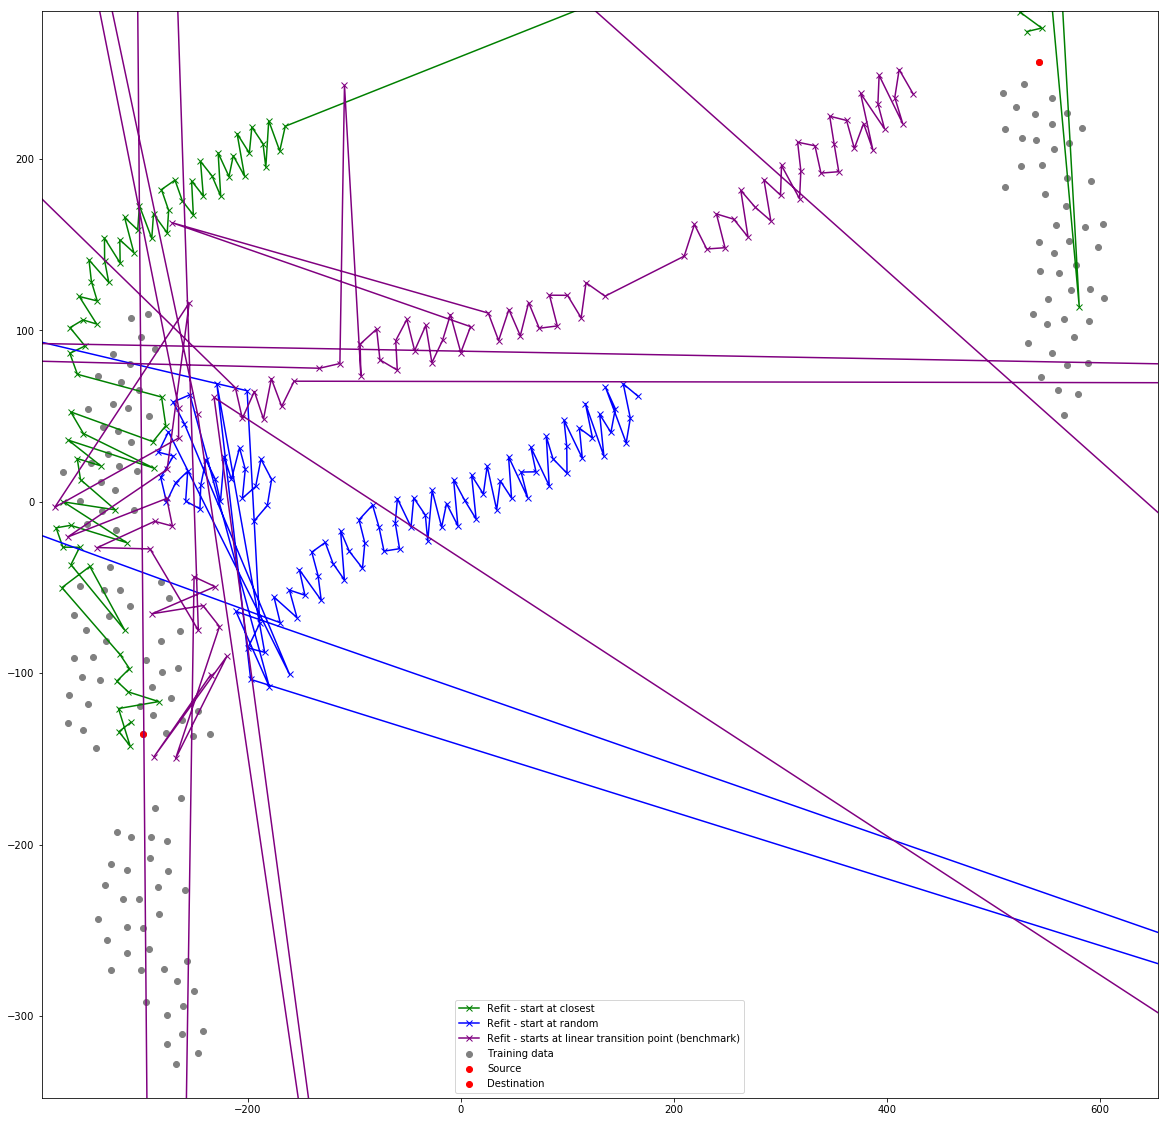

In [170]:
plt.gcf().set_size_inches(20, 20)
legend_list = list()
plt.scatter(Y_iris[:, 0], Y_iris[:, 1], c='gray')
plt.scatter(Y_iris[0, 0], Y_iris[0, 1], c='red')
plt.scatter(Y_iris[100, 0], Y_iris[100, 1], c='red')

plt.plot(y_iris_closest[:, 0], y_iris_closest[:, 1], color='green', marker='x')
legend_list.append("Refit - start at closest")
plt.plot(y_iris_random[:, 0], y_iris_random[:, 1], color='blue', marker = 'x')
legend_list.append("Refit - start at random")
plt.plot(y_iris_linear[:, 0], y_iris_linear[:, 1], color='purple', marker = 'x')
legend_list.append("Refit - starts at linear transition point (benchmark)")

legend_list.append("Training data")
legend_list.append("Source")
legend_list.append("Destination")

plt.xlim([np.min(Y_iris[:, 0])-20, np.max(Y_iris[:, 0])+50])
plt.ylim([np.min(Y_iris[:, 1])-20, np.max(Y_iris[:, 1])+30])
plt.legend(legend_list)
plt.show()

Problems:
- Lack of consistency
[Many others]

## Approach 2. Creating Embedding Function

Ap possible method is to generate a function f(x) -> y. Function takes a sample in original dimensions, and returns its representation in reduced dimensions.

There are several requirements for embedding function [depends on exact scenario]:
   - Continuity. There should be no sudden jumps. Small changes of *x* should correspond to small changes of *y*.
   - Consistency. If an input *x* is the same as one of training data examples, the function should return the same y. It is especially important in dynamics - if the value stayed the same, it should not be perceived as moving. 
   - [more?]

[We propose folloing methods] :
- Lagrange polynomial based on norms [Lagrange-like polynomial with norms to account for multiple diemnsions]
- Piecewise-linear interpolation [name says it all]
- Weighted inverse distance interpolation [weighted sum of Y_i, where weight is equal to normalized inverse distance
between *x* and X_i training sample]

In [171]:
# Just for intuition, here is how those interploations look like
x_1d = np.array([[10],[20],[30],[40]])
y_1d = np.array([[10],[40],[30],[50]])
simple_example_model = dynamic_tsne.DynamicTSNE(perplexity=2)
simple_example_model.incorporate(x_1d, y_1d)

In [172]:
embedder_poly_1d = simple_example_model.generate_embedding_function(embedding_function_type='makeshift-lagrange-norm')
embedder_weighted_1d = simple_example_model.generate_embedding_function(embedding_function_type='weighted-inverse-distance')
embedder_linear_1d = simple_example_model.generate_embedding_function(embedding_function_type='linear-per-dimension')
embedder_lagrange_1d = simple_example_model.generate_embedding_function(embedding_function_type='lagrange-per-dimension')
embedder_rbf = simple_example_model.generate_embedding_function(embedding_function_type='rbf')

In [173]:
x = np.arange(5,45,0.1).reshape((-1,1))
y_poly = embedder_poly_1d(x)
y_weighted = embedder_weighted_1d(x)
y_linear = embedder_linear_1d(x)
y_lagrange = embedder_lagrange_1d(x)
y_rbf = embedder_rbf(x)

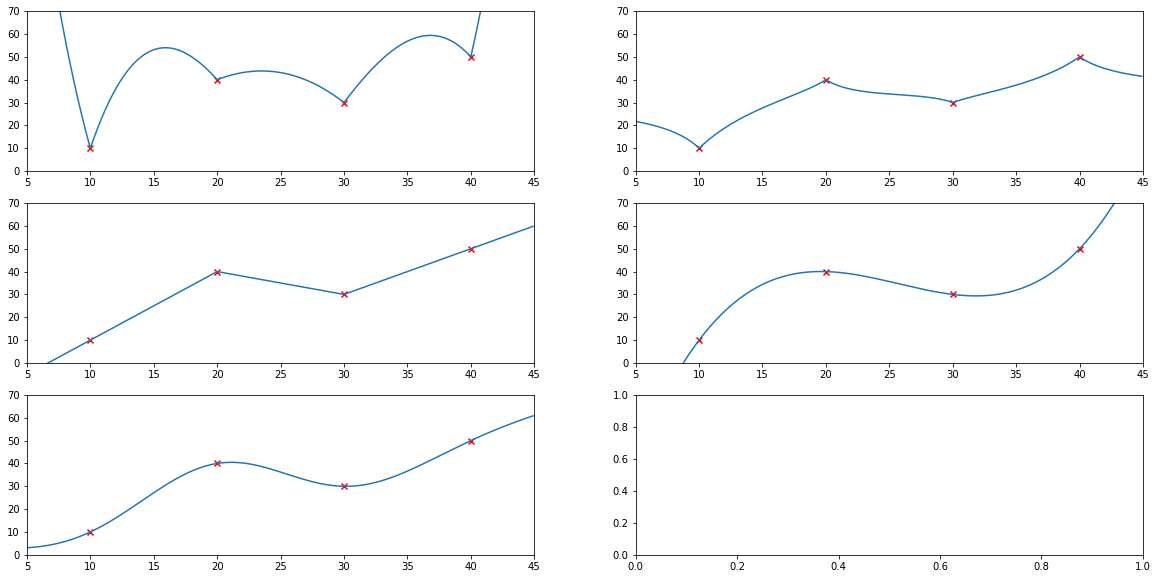

In [174]:
f, ax = plt.subplots(3,2)
f.set_size_inches(20,10)
ax[0,0].plot(x,y_poly)
ax[0,0].scatter(x_1d,y_1d,c='red',marker='x')
ax[0,0].set_ylim([0,70])
ax[0,0].set_xlim([5,45])
ax[0,1].plot(x,y_weighted)
ax[0,1].set_ylim([0,70])
ax[0,1].set_xlim([5,45])
ax[0,1].scatter(x_1d,y_1d,c='red',marker='x')
ax[1,0].plot(x,y_linear)
ax[1,0].set_ylim([0,70])
ax[1,0].set_xlim([5,45])
ax[1,0].scatter(x_1d,y_1d,c='red',marker='x')
ax[1,1].plot(x,y_lagrange)
ax[1,1].set_ylim([0,70])
ax[1,1].set_xlim([5,45])
ax[1,1].scatter(x_1d,y_1d,c='red',marker='x')
ax[2,0].plot(x,y_rbf)
ax[2,0].set_ylim([0,70])
ax[2,0].set_xlim([5,45])
ax[2,0].scatter(x_1d,y_1d,c='red',marker='x')

In [175]:
embedder_poly = dTSNE_digits.generate_embedding_function(embedding_function_type='makeshift-lagrange-norm')
embedder_weighted_one = dTSNE_digits.generate_embedding_function(embedding_function_type='weighted-inverse-distance')
embedder_weighted_half = dTSNE_digits.generate_embedding_function(embedding_function_type='weighted-inverse-distance',
                                              function_kwargs={'power' : 0.5})
embedder_weighted_2 = dTSNE_digits.generate_embedding_function(embedding_function_type='weighted-inverse-distance',
                                              function_kwargs={'power' : 2})
embedder_weighted_3 = dTSNE_digits.generate_embedding_function(embedding_function_type='weighted-inverse-distance',
                                              function_kwargs={'power' : 3})
embedder_weighted_10 = dTSNE_digits.generate_embedding_function(embedding_function_type='weighted-inverse-distance',
                                              function_kwargs={'power' : 10})
embedder_weighted_20 = dTSNE_digits.generate_embedding_function(embedding_function_type='weighted-inverse-distance',
                                              function_kwargs={'power' : 20})
#embedder_linear = dTSNE_digits.generate_embedding_function(embedding_function_type='linear')
embedder_rbf = dTSNE_digits.generate_embedding_function(embedding_function_type='rbf')

In [176]:
#y_poly = embedder_poly(X_digits_transition, verbose = 2)
y_w_1 = embedder_weighted_one(X_digits_transition)
y_w_half = embedder_weighted_half(X_digits_transition)

In [177]:
y_w_2 = embedder_weighted_2(X_digits_transition)
y_w_3 = embedder_weighted_3(X_digits_transition)
y_w_10 = embedder_weighted_10(X_digits_transition)
y_w_20 = embedder_weighted_20(X_digits_transition)
#y_linear = embedder_linear(X_digits_transition)
y_rbf = embedder_rbf(X_digits_transition)

In [178]:
start_index = 500
end_index = 600
steps = 100
X_digits_transition2 = [X_digits[start_index, :] + (X_digits[end_index,:] - X_digits[start_index, :])*i/steps
                       for i in range(steps+1)]
y_2w_2 = embedder_weighted_2(X_digits_transition2)
y_2w_3 = embedder_weighted_3(X_digits_transition2)
y_2w_10 = embedder_weighted_10(X_digits_transition2)
y_2w_20 = embedder_weighted_20(X_digits_transition2)
y_2rbf = embedder_rbf(X_digits_transition2)

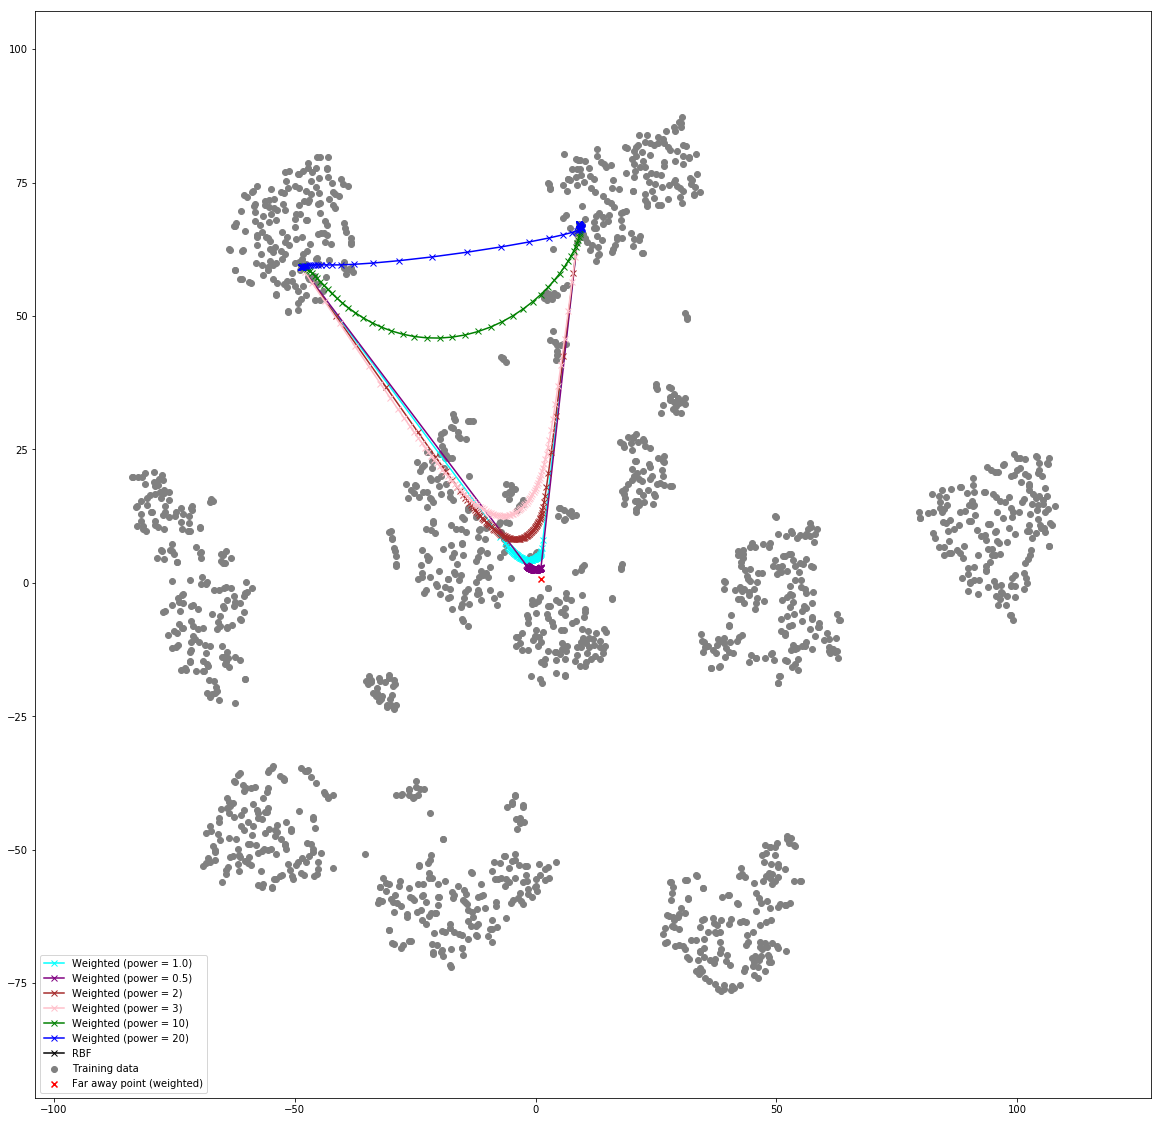

[[ 318.59357343   81.5106995 ]]


In [185]:
plt.gcf().set_size_inches(20, 20)
legend_list = list()
plt.scatter(Y_digits[:, 0], Y_digits[:, 1], c='gray')

X_far = [100]*64
y_far = embedder_weighted_one(X_far)
plt.scatter(y_far[:, 0], y_far[:, 1], c='red',marker='x')

#plt.plot(y_poly[:, 0], y_poly[:, 1], color='red', marker='x')
#legend_list.append("Polynomial interpolation")
plt.plot(y_w_1[:, 0], y_w_1[:, 1], color='cyan', marker = 'x')
legend_list.append("Weighted (power = 1.0)")
plt.plot(y_w_half[:, 0], y_w_half[:, 1], color='purple', marker = 'x')
legend_list.append("Weighted (power = 0.5)")
plt.plot(y_w_2[:, 0], y_w_2[:, 1], color='brown', marker = 'x')
legend_list.append("Weighted (power = 2)")
plt.plot(y_w_3[:, 0], y_w_3[:, 1], color='pink', marker = 'x')
legend_list.append("Weighted (power = 3)")
plt.plot(y_w_10[:, 0], y_w_10[:, 1], color='green', marker = 'x')
legend_list.append("Weighted (power = 10)")
plt.plot(y_w_20[:, 0], y_w_20[:, 1], color='blue', marker = 'x')
legend_list.append("Weighted (power = 20)")
#plt.plot(y_linear[:, 0], y_linear[:, 1], color='black', marker = 'x')
#legend_list.append("Linear")
plt.plot(y_rbf[:, 0], y_rbf[:, 1], color='black', marker = 'x')
legend_list.append("RBF")


legend_list.append("Training data")
legend_list.append("Far away point (weighted)")

plt.xlim([np.min(Y_digits[:, 0])-20, np.max(Y_digits[:, 0])+20])
plt.ylim([np.min(Y_digits[:, 1])-20, np.max(Y_digits[:, 1])+20])
plt.legend(legend_list)
plt.show()

y_far_rbf = embedder_rbf(X_far)
print(y_far_rbf)

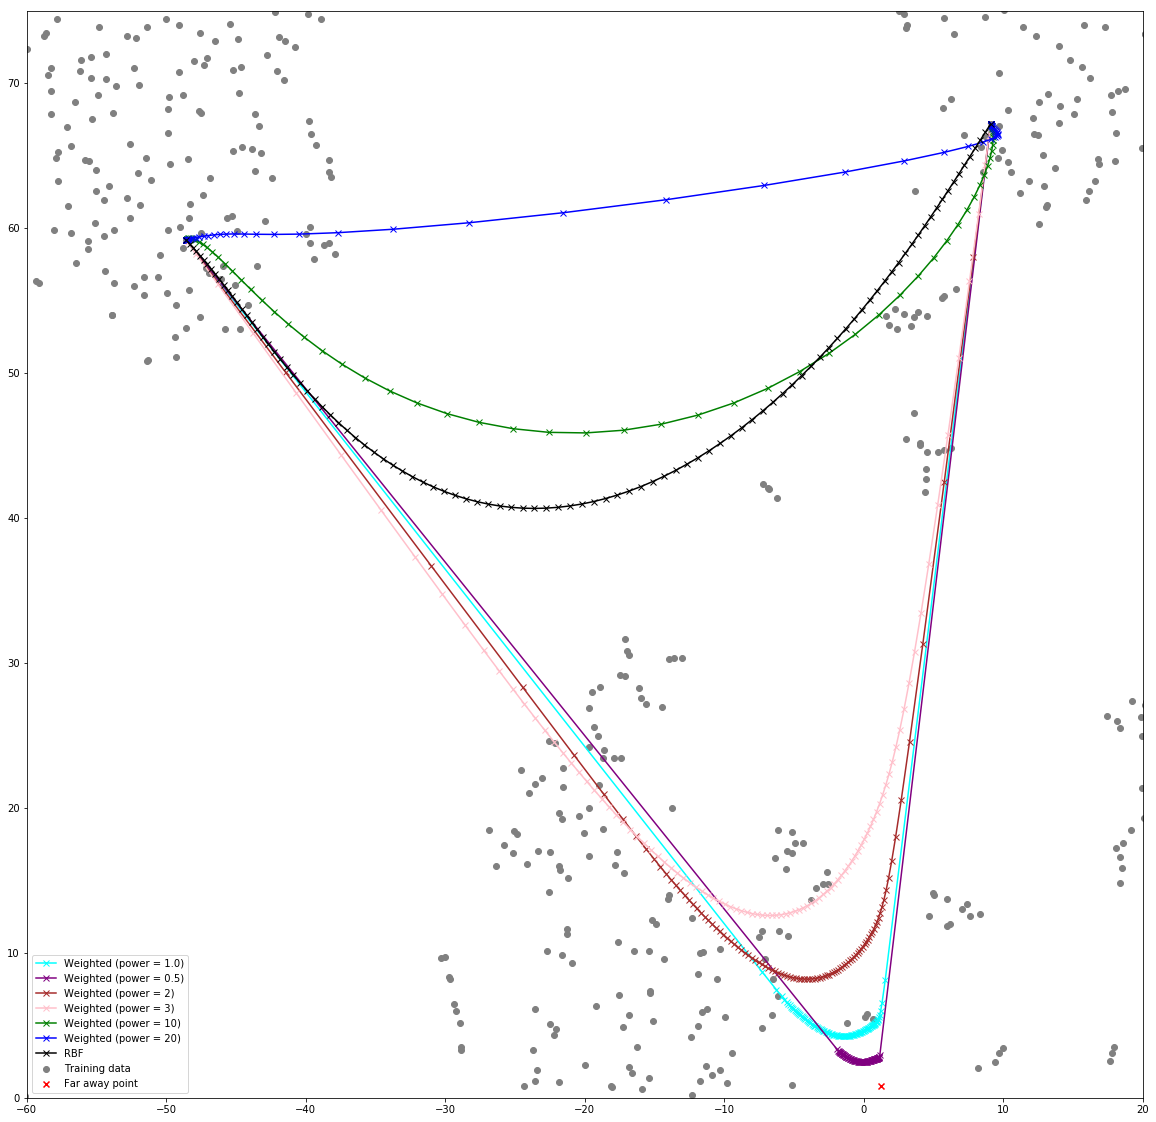

In [180]:
plt.gcf().set_size_inches(20, 20)
legend_list = list()
plt.scatter(Y_digits[:, 0], Y_digits[:, 1], c='gray')

X_far = [100]*64
y_far = embedder_weighted_one(X_far)

plt.scatter(y_far[:, 0], y_far[:, 1], c='red',marker='x')

#plt.plot(y_poly[:, 0], y_poly[:, 1], color='red', marker='x')
#legend_list.append("Polynomial interpolation")
plt.plot(y_w_1[:, 0], y_w_1[:, 1], color='cyan', marker = 'x')
legend_list.append("Weighted (power = 1.0)")
plt.plot(y_w_half[:, 0], y_w_half[:, 1], color='purple', marker = 'x')
legend_list.append("Weighted (power = 0.5)")
plt.plot(y_w_2[:, 0], y_w_2[:, 1], color='brown', marker = 'x')
legend_list.append("Weighted (power = 2)")
plt.plot(y_w_3[:, 0], y_w_3[:, 1], color='pink', marker = 'x')
legend_list.append("Weighted (power = 3)")
plt.plot(y_w_10[:, 0], y_w_10[:, 1], color='green', marker = 'x')
legend_list.append("Weighted (power = 10)")
plt.plot(y_w_20[:, 0], y_w_20[:, 1], color='blue', marker = 'x')
legend_list.append("Weighted (power = 20)")
#plt.plot(y_linear[:, 0], y_linear[:, 1], color='black', marker = 'x')
#legend_list.append("Linear")
plt.plot(y_rbf[:, 0], y_rbf[:, 1], color='black', marker = 'x')
legend_list.append("RBF")


legend_list.append("Training data")
legend_list.append("Far away point")

plt.xlim([-60, 20])
plt.ylim([0, 75])
plt.legend(legend_list)
plt.show()

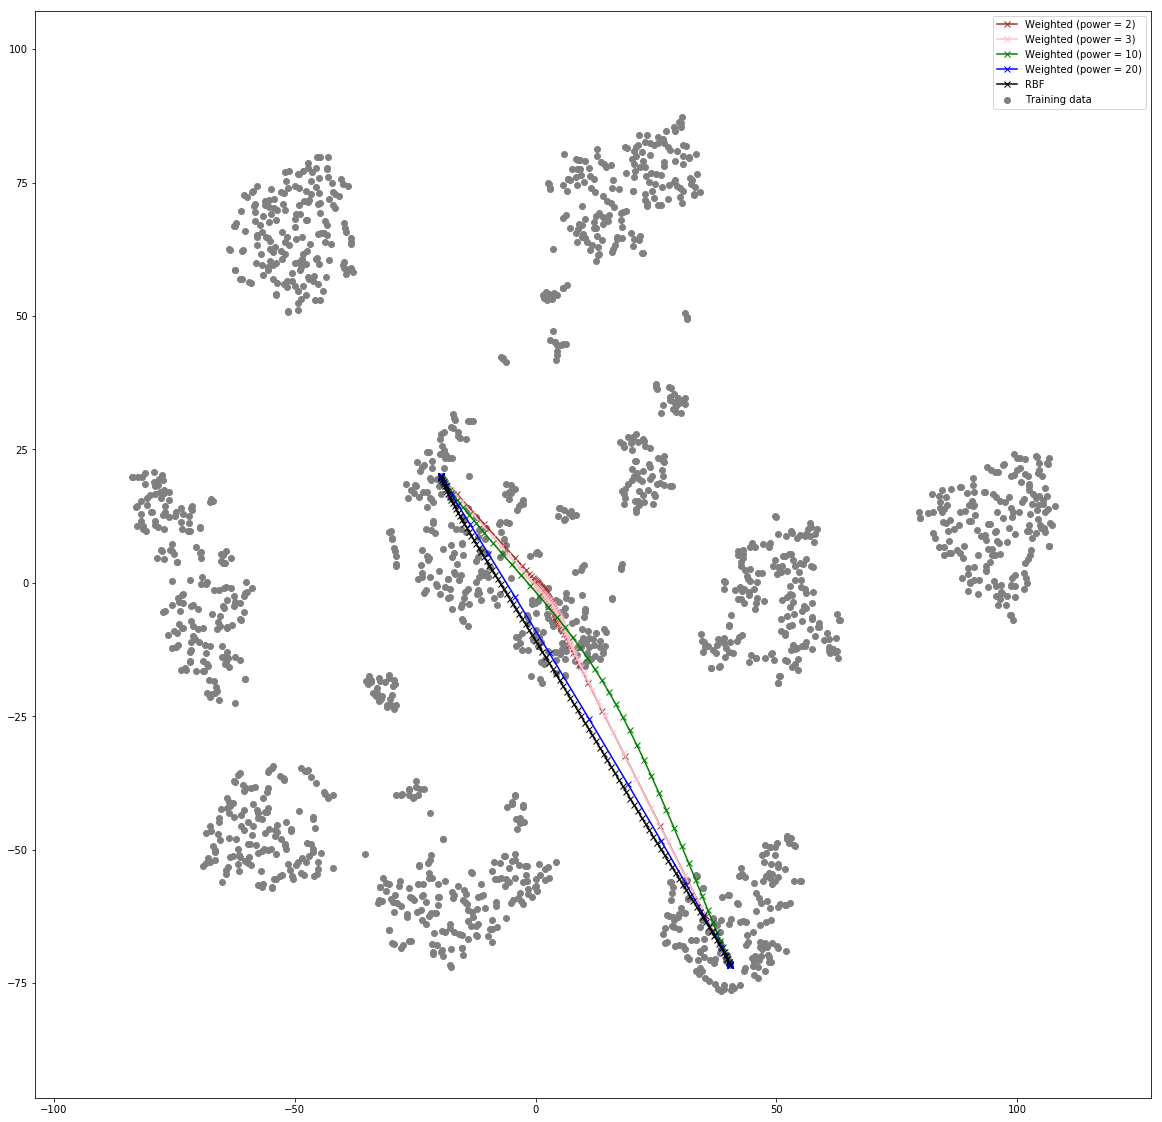

In [181]:
plt.gcf().set_size_inches(20, 20)
legend_list = list()
plt.scatter(Y_digits[:, 0], Y_digits[:, 1], c='gray')

#plt.plot(y_poly[:, 0], y_poly[:, 1], color='red', marker='x')
#legend_list.append("Polynomial interpolation")
plt.plot(y_2w_2[:, 0], y_2w_2[:, 1], color='brown', marker = 'x')
legend_list.append("Weighted (power = 2)")
plt.plot(y_2w_3[:, 0], y_2w_3[:, 1], color='pink', marker = 'x')
legend_list.append("Weighted (power = 3)")
plt.plot(y_2w_10[:, 0], y_2w_10[:, 1], color='green', marker = 'x')
legend_list.append("Weighted (power = 10)")
plt.plot(y_2w_20[:, 0], y_2w_20[:, 1], color='blue', marker = 'x')
legend_list.append("Weighted (power = 20)")
#plt.plot(y_linear[:, 0], y_linear[:, 1], color='black', marker = 'x')
#legend_list.append("Linear")
plt.plot(y_2rbf[:, 0], y_2rbf[:, 1], color='black', marker = 'x')
legend_list.append("RBF")


legend_list.append("Training data")

plt.xlim([np.min(Y_digits[:, 0])-20, np.max(Y_digits[:, 0])+20])
plt.ylim([np.min(Y_digits[:, 1])-20, np.max(Y_digits[:, 1])+20])
plt.legend(legend_list)
plt.show()

[Lagrange polynomial]:
- Pro: Smooth [No, it's not. Original Largrange polynomial is, but here we have norm rather than simple subtraction. Norm is not smooth, and it is exactly not smooth at those points.]
- Con: Tends to shoot far away.
- Con: Very slow
Those cons outweights all pros.

Weighted inverse distance interpolation can produce [some strange effects]:
- "Pull-to-the-center"
- "All-marks-at-the center" or "all-marks-at-the-sides"
Those are 2 sides of the same effect.

Weighted sum of distance:
- Pro: [very configurable]
- Con: Requires carefully choosing parameter.
- Con: [bounded; far away points tend to be at the center]
- Con: [passing through clusters that it does not belong to]
Despite all cons, looks much better than polynomial.

Linear interpolation:
- [think of pros and cons]

1D per-dimension interpolation:
- [easy, can be a wrapper around any method]
- Con: [Relationships between dimensions are lost.]
- Con: Can become unusable if several points share the same value along one of the dimensions. Moreover, if distant points have close value along one of the dimensions, the results can become unstable [see jagged line].

RBFs:
- [Simply the best]
- Con: "Passing through clusters"

In [182]:
embedder_poly_iris = dTSNE_iris.generate_embedding_function(embedding_function_type='makeshift-lagrange-norm')
embedder_weighted_one_iris = dTSNE_iris.generate_embedding_function(embedding_function_type='weighted-inverse-distance')
embedder_weighted_half_iris = dTSNE_iris.generate_embedding_function(embedding_function_type='weighted-inverse-distance',
                                              function_kwargs={'power' : 0.5})
embedder_weighted_2_iris = dTSNE_iris.generate_embedding_function(embedding_function_type='weighted-inverse-distance',
                                              function_kwargs={'power' : 2})
embedder_linear_iris = dTSNE_iris.generate_embedding_function(embedding_function_type='linear')
embedder_rbf_iris = dTSNE_iris.generate_embedding_function(embedding_function_type='rbf')

In [186]:
y_poly_iris = embedder_poly_iris(Xtransition_iris, verbose = 2)
y_w_1_iris = embedder_weighted_one_iris(Xtransition_iris)
y_w_half_iris = embedder_weighted_half_iris(Xtransition_iris)
y_w_2_iris = embedder_weighted_2_iris(Xtransition_iris)
y_linear_iris = embedder_linear_iris(Xtransition_iris)
y_rbf_iris = embedder_rbf_iris(Xtransition_iris)

makeshift-lagrange-norm: Embedding sample  0
makeshift-lagrange-norm: Embedding sample  1
makeshift-lagrange-norm: Embedding sample  2
makeshift-lagrange-norm: Embedding sample  3
makeshift-lagrange-norm: Embedding sample  4
makeshift-lagrange-norm: Embedding sample  5
makeshift-lagrange-norm: Embedding sample  6
makeshift-lagrange-norm: Embedding sample  7
makeshift-lagrange-norm: Embedding sample  8
makeshift-lagrange-norm: Embedding sample  9
makeshift-lagrange-norm: Embedding sample  10
makeshift-lagrange-norm: Embedding sample  11
makeshift-lagrange-norm: Embedding sample  12
makeshift-lagrange-norm: Embedding sample  13
makeshift-lagrange-norm: Embedding sample  14
makeshift-lagrange-norm: Embedding sample  15
makeshift-lagrange-norm: Embedding sample  16
makeshift-lagrange-norm: Embedding sample  17
makeshift-lagrange-norm: Embedding sample  18
makeshift-lagrange-norm: Embedding sample  19
makeshift-lagrange-norm: Embedding sample  20
makeshift-lagrange-norm: Embedding sample  2

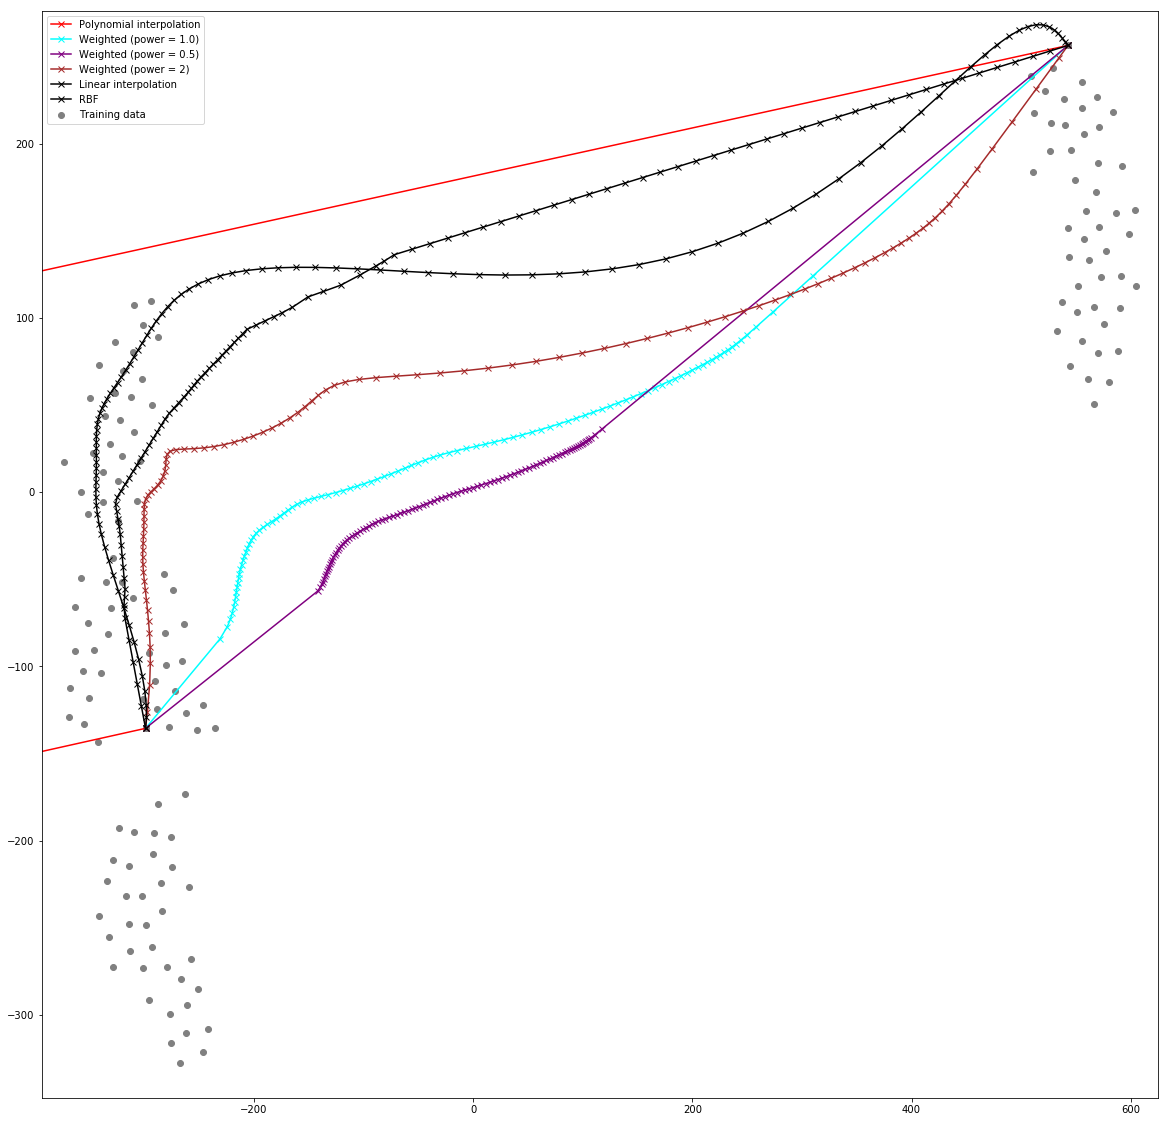

In [187]:
plt.gcf().set_size_inches(20, 20)
legend_list = list()
plt.scatter(Y_iris[:, 0], Y_iris[:, 1], c='gray')

#X_far = [100]*64
#y_far = embedder_weighted_one(X_far)

#plt.scatter(y_far[:, 0], y_far[:, 1], c='red',marker='x')

plt.plot(y_poly_iris[:, 0], y_poly_iris[:, 1], color='red', marker='x')
legend_list.append("Polynomial interpolation")
plt.plot(y_w_1_iris[:, 0], y_w_1_iris[:, 1], color='cyan', marker = 'x')
legend_list.append("Weighted (power = 1.0)")
plt.plot(y_w_half_iris[:, 0], y_w_half_iris[:, 1], color='purple', marker = 'x')
legend_list.append("Weighted (power = 0.5)")
plt.plot(y_w_2_iris[:, 0], y_w_2_iris[:, 1], color='brown', marker = 'x')
legend_list.append("Weighted (power = 2)")
plt.plot(y_linear_iris[:, 0], y_linear_iris[:, 1], color='black', marker = 'x')
legend_list.append("Linear interpolation")
plt.plot(y_rbf_iris[:, 0], y_rbf_iris[:, 1], color='black', marker = 'x')
legend_list.append("RBF")


legend_list.append("Training data")
legend_list.append("Far away point")

plt.xlim([np.min(Y_iris[:, 0])-20, np.max(Y_iris[:, 0])+20])
plt.ylim([np.min(Y_iris[:, 1])-20, np.max(Y_iris[:, 1])+20])
plt.legend(legend_list)
plt.show()

# MORE TESTS
- [Done] Transition test. Transofmring one sample into another. Where it will end up? How will it go? Will it pass through the clusters that it does not belong to?
- [Likely to succeed] Create a point that belongs to one of the clusters. Will it appear at the appropriate cluster?
- Create a point that does not belong to any cluster. where will it appear?
- Create a complete outlier. Where it will appear?

Use that tests as criteria. Make a table.

# TODO



In [ ]:
x = np.array([[1,2],[3,4],[5,6]])
list(x.T)

In [241]:
print(np.where(labels_digits==7))

(array([  75,  101,  106,  152,  188,  189,  213,  214,  229,  254,  280,
        313,  383,  429,  430,  432,  436,  440,  463,  465,  469,  477,
        508,  510,  511,  512,  513,  514,  515,  534,  551,  554,  557,
        578,  590,  603,  605,  606,  607,  624,  625,  628,  629,  648,
        649,  650,  651,  652,  655,  660,  665,  679,  681,  682,  683,
        684,  691,  695,  697,  706,  707,  713,  725,  738,  742,  745,
        746,  777,  781,  782,  783,  784,  785,  789,  799,  800,  805,
        807,  815,  833,  836,  850,  851,  862,  865,  867,  885,  891,
        901,  903,  904,  916,  920,  937,  957,  964,  972,  977,  987,
        988,  991,  992,  993,  996,  998, 1000, 1001, 1006, 1047, 1048,
       1053, 1069, 1080, 1086, 1090, 1093, 1095, 1101, 1121, 1132, 1144,
       1146, 1147, 1151, 1156, 1168, 1177, 1181, 1191, 1192, 1193, 1195,
       1224, 1257, 1262, 1272, 1273, 1277, 1278, 1285, 1295, 1323, 1344,
       1348, 1351, 1355, 1372, 1395, 1405, 1410, 1